# Sessa Empirical Estimator

## Setup

### Import Libraries and Set Paths

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# DBScan Libraries
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

CSV_PATH = './csv-files/'

### Setup sample data

In [317]:
file_path = CSV_PATH + "med_events.csv"

# Try to read the CSV file into a DataFrame
try:
    med_events = pd.read_csv(file_path)
    print("CSV file loaded successfully!")
    
    # Convert date column to datetime (assuming 'DATE' is the column name in your CSV)
    med_events["DATE"] = pd.to_datetime(med_events["DATE"])

    # Change column names
    med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

    # Display the first few rows
    print(med_events.head())

except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Ensure the file exists.")



CSV file loaded successfully!
   pnr       eksd  perday   ATC  dur_original
0    1 2020-08-05       4  medA            17
1    1 2021-06-11       6  medB            27
2    1 2022-10-21       9  medA            45
3    2 2020-02-02       9  medB            38
4    2 2020-06-26       9  medB            46


## Callable Functions

### SEE Using K-Means

In [320]:
def see(arg1):
    # Filter dataset for the selected medication
    subset = med_events[med_events["ATC"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["pnr", "eksd"]).copy()
    subset["prev_eksd"] = subset.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    subset = subset.dropna().copy()
    
    # Select one random record per patient
    subset = subset.groupby("pnr").sample(n=1, random_state=1234).copy()

    # Compute event interval (time difference)
    subset["event_interval"] = (subset["eksd"] - subset["prev_eksd"]).dt.days
    
    # Compute ECDF
    sorted_intervals = np.sort(subset["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_val = sorted_intervals[int(0.8 * len(sorted_intervals))]
    subset_filtered = subset[subset["event_interval"] <= max_val].copy()

    # Density plot of log-transformed event intervals
    kde = gaussian_kde(np.log(subset_filtered["event_interval"]))
    x_vals = np.linspace(min(np.log(subset_filtered["event_interval"])), 
                         max(np.log(subset_filtered["event_interval"])), 100)
    y_vals = kde(x_vals)

    # Silhouette Analysis
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(x_vals.reshape(-1, 1))

    best_clusters = []
    best_score = -1
    best_k = 2
    
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=1234, n_init=10)
        labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        best_clusters.append((k, score))
        if score > best_score:
            best_score = score
            best_k = k

    # K-means Clustering
    subset_filtered = subset_filtered.copy()  # Ensure a fresh copy before modification
    subset_filtered.loc[:, "cluster"] = KMeans(n_clusters=best_k, random_state=1234, n_init=10).fit_predict(subset_filtered[["event_interval"]])

    # Cluster summary
    cluster_summary = subset_filtered.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()
    
    # Merge clusters back to main dataset
    results = subset_filtered.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = med_events[med_events["ATC"] == arg1].copy()
    final_result = final_result.merge(results[["pnr", "median", "cluster"]], on="pnr", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result


### SEE Using DBSCAN

In [321]:
def see_dbscan(arg1):
    # Filter dataset for the selected medication
    subset = med_events[med_events["ATC"] == arg1].copy()
    
    # Sort and create a previous prescription date column
    subset = subset.sort_values(["pnr", "eksd"]).copy()
    subset["prev_eksd"] = subset.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    subset = subset.dropna().copy()
    
    # Select one random record per patient
    subset = subset.groupby("pnr").sample(n=1, random_state=1234).copy()

    # Compute event interval (time difference)
    subset["event_interval"] = (subset["eksd"] - subset["prev_eksd"]).dt.days
    
    # Compute ECDF
    sorted_intervals = np.sort(subset["event_interval"])
    ecdf_y = np.arange(1, len(sorted_intervals) + 1) / len(sorted_intervals)

    # Keep only the lower 80% of ECDF
    max_val = sorted_intervals[int(0.8 * len(sorted_intervals))]
    subset_filtered = subset[subset["event_interval"] <= max_val].copy()

    # Density plot of log-transformed event intervals
    kde = gaussian_kde(np.log(subset_filtered["event_interval"]))
    x_vals = np.linspace(min(np.log(subset_filtered["event_interval"])), 
                         max(np.log(subset_filtered["event_interval"])), 100)
    y_vals = kde(x_vals)

    # Normalize the data for clustering
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(subset_filtered[["event_interval"]])

    # Determine the optimal epsilon (eps) using k-distance method
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(scaled_data)
    distances, _ = neigh.kneighbors(scaled_data)
    k_distances = np.sort(distances[:, -1])  # Take the 5th neighbor distance

    # Choose eps as the "knee" point (approximation: 90th percentile of distances)
    eps_value = np.percentile(k_distances, 90)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps_value, min_samples=5)
    subset_filtered.loc[:, "cluster"] = dbscan.fit_predict(scaled_data)

    # Handle noise points (DBSCAN assigns -1 to noise)
    subset_filtered.loc[subset_filtered["cluster"] == -1, "cluster"] = np.nan

    # Cluster summary
    cluster_summary = subset_filtered.groupby("cluster")["event_interval"].agg(["min", "max", "median"]).reset_index()

    # Merge clusters back to main dataset
    results = subset_filtered.merge(cluster_summary, on="cluster", how="left")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Assign cluster to all data
    final_result = med_events[med_events["ATC"] == arg1].copy()
    final_result = final_result.merge(results[["pnr", "median", "cluster"]], on="pnr", how="left")

    # Fill missing cluster values safely
    final_result["cluster"] = final_result["cluster"].fillna(0)
    final_result["median"] = final_result["median"].fillna(results["median"].median())

    return final_result


### SEE Assumption

In [322]:
def see_assumption(data):
    data = data.copy()
    
    # Sort and create previous prescription date column
    data.sort_values(["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    
    # Remove rows where prev_eksd is NaN
    data = data.dropna()
    
    # Compute duration between prescriptions
    data["duration"] = (data["eksd"] - data["prev_eksd"]).dt.days
    
    # Assign sequence number per patient
    data["p_number"] = data.groupby("pnr").cumcount() + 1
    
    # Filter only patients with at least 2 prescriptions
    data = data[data["p_number"] >= 2]
    
    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data["p_number"], y=data["duration"])
    plt.title("Duration Between Prescriptions")
    plt.xlabel("Prescription Number")
    plt.ylabel("Duration (days)")
    
    # Compute median of medians per patient
    medians_of_medians = data.groupby("pnr")["duration"].median()
    
    # Overlay median lines
    plt.axhline(medians_of_medians.median(), color="red", linestyle="dashed")
    plt.show()

## Execution

### Using K-Means

In [323]:
med_a = see("medA")
med_a

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2020-08-05,4,medA,17,61.0,0.0
1,1,2022-10-21,9,medA,45,61.0,0.0
2,2,2020-07-20,9,medA,30,200.0,1.0
3,2,2021-01-11,9,medA,29,200.0,1.0
4,2,2021-04-21,4,medA,45,200.0,1.0
...,...,...,...,...,...,...,...
546,100,2021-07-27,4,medA,35,61.0,0.0
547,100,2021-10-19,6,medA,33,61.0,0.0
548,100,2021-12-22,3,medA,14,61.0,0.0
549,100,2022-04-16,8,medA,46,61.0,0.0


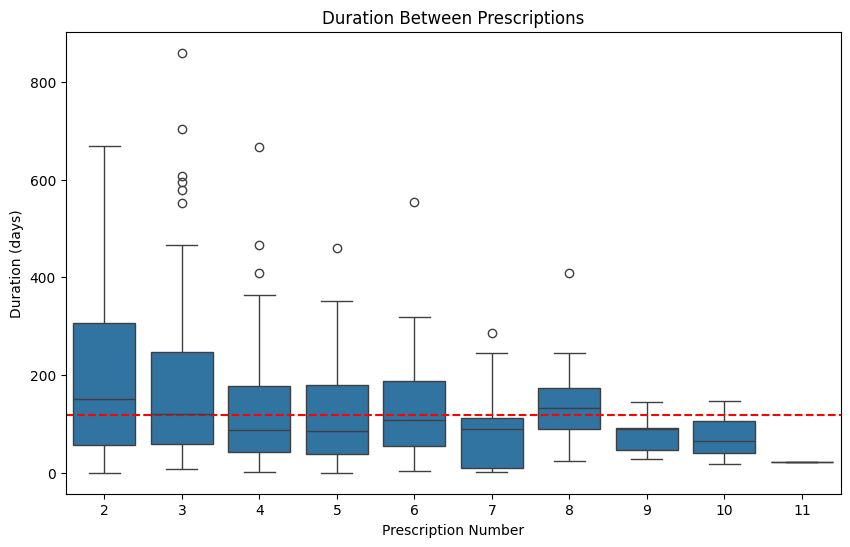

In [324]:
see_assumption(med_a)

### Using DBScan

In [325]:
med_b = see_dbscan("medB")
med_b

,pnr,eksd,perday,ATC,dur_original,median,cluster
0,1,2021-06-11,6,medB,27,54.0,0.0
1,2,2020-02-02,9,medB,38,54.0,0.0
2,2,2020-06-26,9,medB,46,54.0,0.0
3,2,2020-07-05,4,medB,44,54.0,0.0
4,2,2020-10-24,9,medB,11,54.0,0.0
...,...,...,...,...,...,...,...
524,98,2022-05-24,6,medB,49,54.0,0.0
525,99,2020-06-22,2,medB,34,54.0,0.0
526,99,2020-08-11,5,medB,29,54.0,0.0
527,99,2021-05-19,6,medB,31,54.0,0.0
